(edgar_2_fluxy)=
# EDGAR to fluxy 

Fluxy is a Python package for plotting athmospheric modelling inversion results.
With emiproc we can produce prior emission gridded fluxes compatible with fluxy.

This shows how to convert EDGAR emissions to the fluxy format and how to plot them.

More information about fluxy can be found here:
https://github.com/openghg/fluxy



In [ ]:
from pathlib import Path
from emiproc.inventories.edgar import download_edgar_files
from emiproc.inventories.edgar import EDGARv8
from emiproc.grids import RegularGrid
from emiproc.regrid import remap_inventory
from emiproc.inventories.utils import group_categories
from emiproc.speciation import merge_substances

from emiproc import FILES_DIR
import matplotlib.pyplot as plt


plt.style.use("default")

local_dir = FILES_DIR / "edgar"
local_dir.mkdir(exist_ok=True)

# Where we will save the fluxy files
fluxy_dir = local_dir / "fluxy" / "edgar_emiproc"
fluxy_dir.mkdir(parents=True, exist_ok=True)

years = range(2014, 2024)

In [ ]:
# Download EDGAR files for the years we want
for year in years:
    download_edgar_files(local_dir / "data"/  str(year), year=year, substances=["CH4", "CO2", "CO2bio"])


## Processing inventory 

If you will load and process a lot of data, it is recommended to do all of this in a function,
such that the memory is released after processing each inventory.

If you want to know more about the processing steps, please check other tutorials.

In [3]:
# Output grid
# Somewhere over Europe and also until the east coast of the US.
grid = RegularGrid(xmin=-74, xmax=7, ymin=35.5, ymax=71.2, nx=170, ny=120)
grid


def process_inventory(year: int) -> None:

    inv = EDGARv8(local_dir / "data" / str(year) / "*.nc", year=year)

    # Calculate the weights mapping only one time and save them for future use
    remapped = remap_inventory(
        inv, grid, weights_file=local_dir / ".weights_remap_fluxygrid_2"
    )

    merged = merge_substances(remapped, {"CO2": ["CO2", "CO2bio"]})
    groupped = group_categories(
        merged,
        categories_group={
            "agriculture": [
                "Agricultural soils",
                "Agricultural waste burning",
                "Manure management",
            ],
            "industry": [
                "Chemical processes",
                "Power Industry",
                "Oil refineries and Transformation industry",
                "Fuel exploitation",
                "Energy for buildings",
                "Combustion for manufacturing",
                "Iron and steel production",
                "Non energy use of fuels",
                "Solvents and products use",
                "Non-ferrous metals production",
                "Non-metallic minerals production",
            ],
            "livestock": ["Enteric fermentation"],
            "waste": [
                "Waste water handling",
                "Solid waste incineration",
                "Solid waste landfills",
            ],
            "transportation": [
                "Aviation climbing_and_descent",
                "Aviation cruise",
                "Aviation landing_and_takeoff",
                "Railways, pipelines, off-road transport",
                "Shipping",
                "Road transportation",
            ],
        },
    )

    return groupped

In [ ]:


# Load the edgar inventory

invs = [process_inventory(year) for year in years]


## Exporting the Inventory

One of the main features of emiproc is its ability to export the inventory to various types of simulation inputs.

In this example, we will save the inventories for each year to a NetCDF file that follows the fluxy format.


In [ ]:
from emiproc.exports.fluxy import export_fluxy

# Export the inventory to fluxy format
export_fluxy(invs, fluxy_dir, transport_model="EmiprocEdgar")

## Using fluxy to plot the inventory

First we need to read the data, this is done wit the `read_model_output` function.

In [ ]:
from fluxy.io import  read_model_output

dss_fluxy = read_model_output(
    
    data_dir=fluxy_dir,
    file_type='flux', # Fluxy can plot also concentrations, but in emiproc we only use fluxes
    species="CH4",
    models=["EmiprocEdgar"],
)
dss_fluxy

{'EmiprocEdgar': <xarray.Dataset> Size: 5MB
 Dimensions:                   (country: 18, latitude: 120, longitude: 170,
                                time: 10)
 Coordinates:
   * longitude                 (longitude) float64 1kB -73.76 -73.29 ... 6.762
   * latitude                  (latitude) float64 960B 35.65 35.95 ... 71.05
   * country                   (country) <U3 216B 'CAN' 'USA' ... 'ISL' 'MAR'
   * time                      (time) datetime64[ns] 80B 2014-06-01 ... 2023-0...
 Data variables:
     country_fraction          (country, latitude, longitude) float64 3MB ...
     flux_total_prior          (time, latitude, longitude) float64 2MB ...
     flux_total_prior_country  (time, country) float64 1kB ...
 Attributes:
     frequency:  yearly
     species:    CH4}

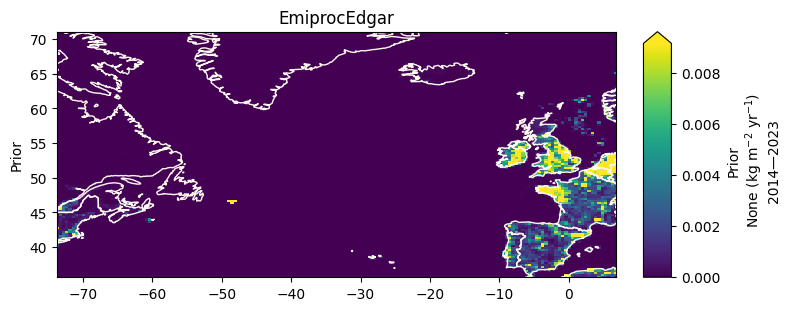

In [ ]:
from fluxy.plots.flux_map import plot_flux_map


# This function is a simple flux map
fig = plot_flux_map(
    dss_fluxy,
    species='CO2',
    # Set this to only see the inventory
    # In fluxy they run inversion results, in our case we only have the prior inventory
    only = "prior",
)

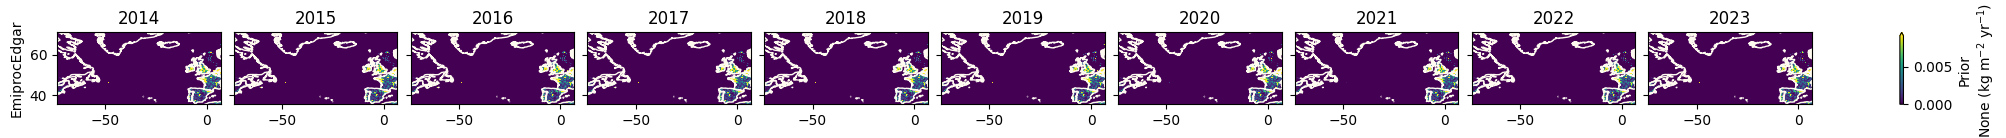

In [ ]:
from fluxy.plots.flux_map import plot_flux_map_over_time


# This function plots the map over time (years)
fig = plot_flux_map_over_time(
    dss_fluxy,
    var="flux_total_prior",
    species="CO2",
)

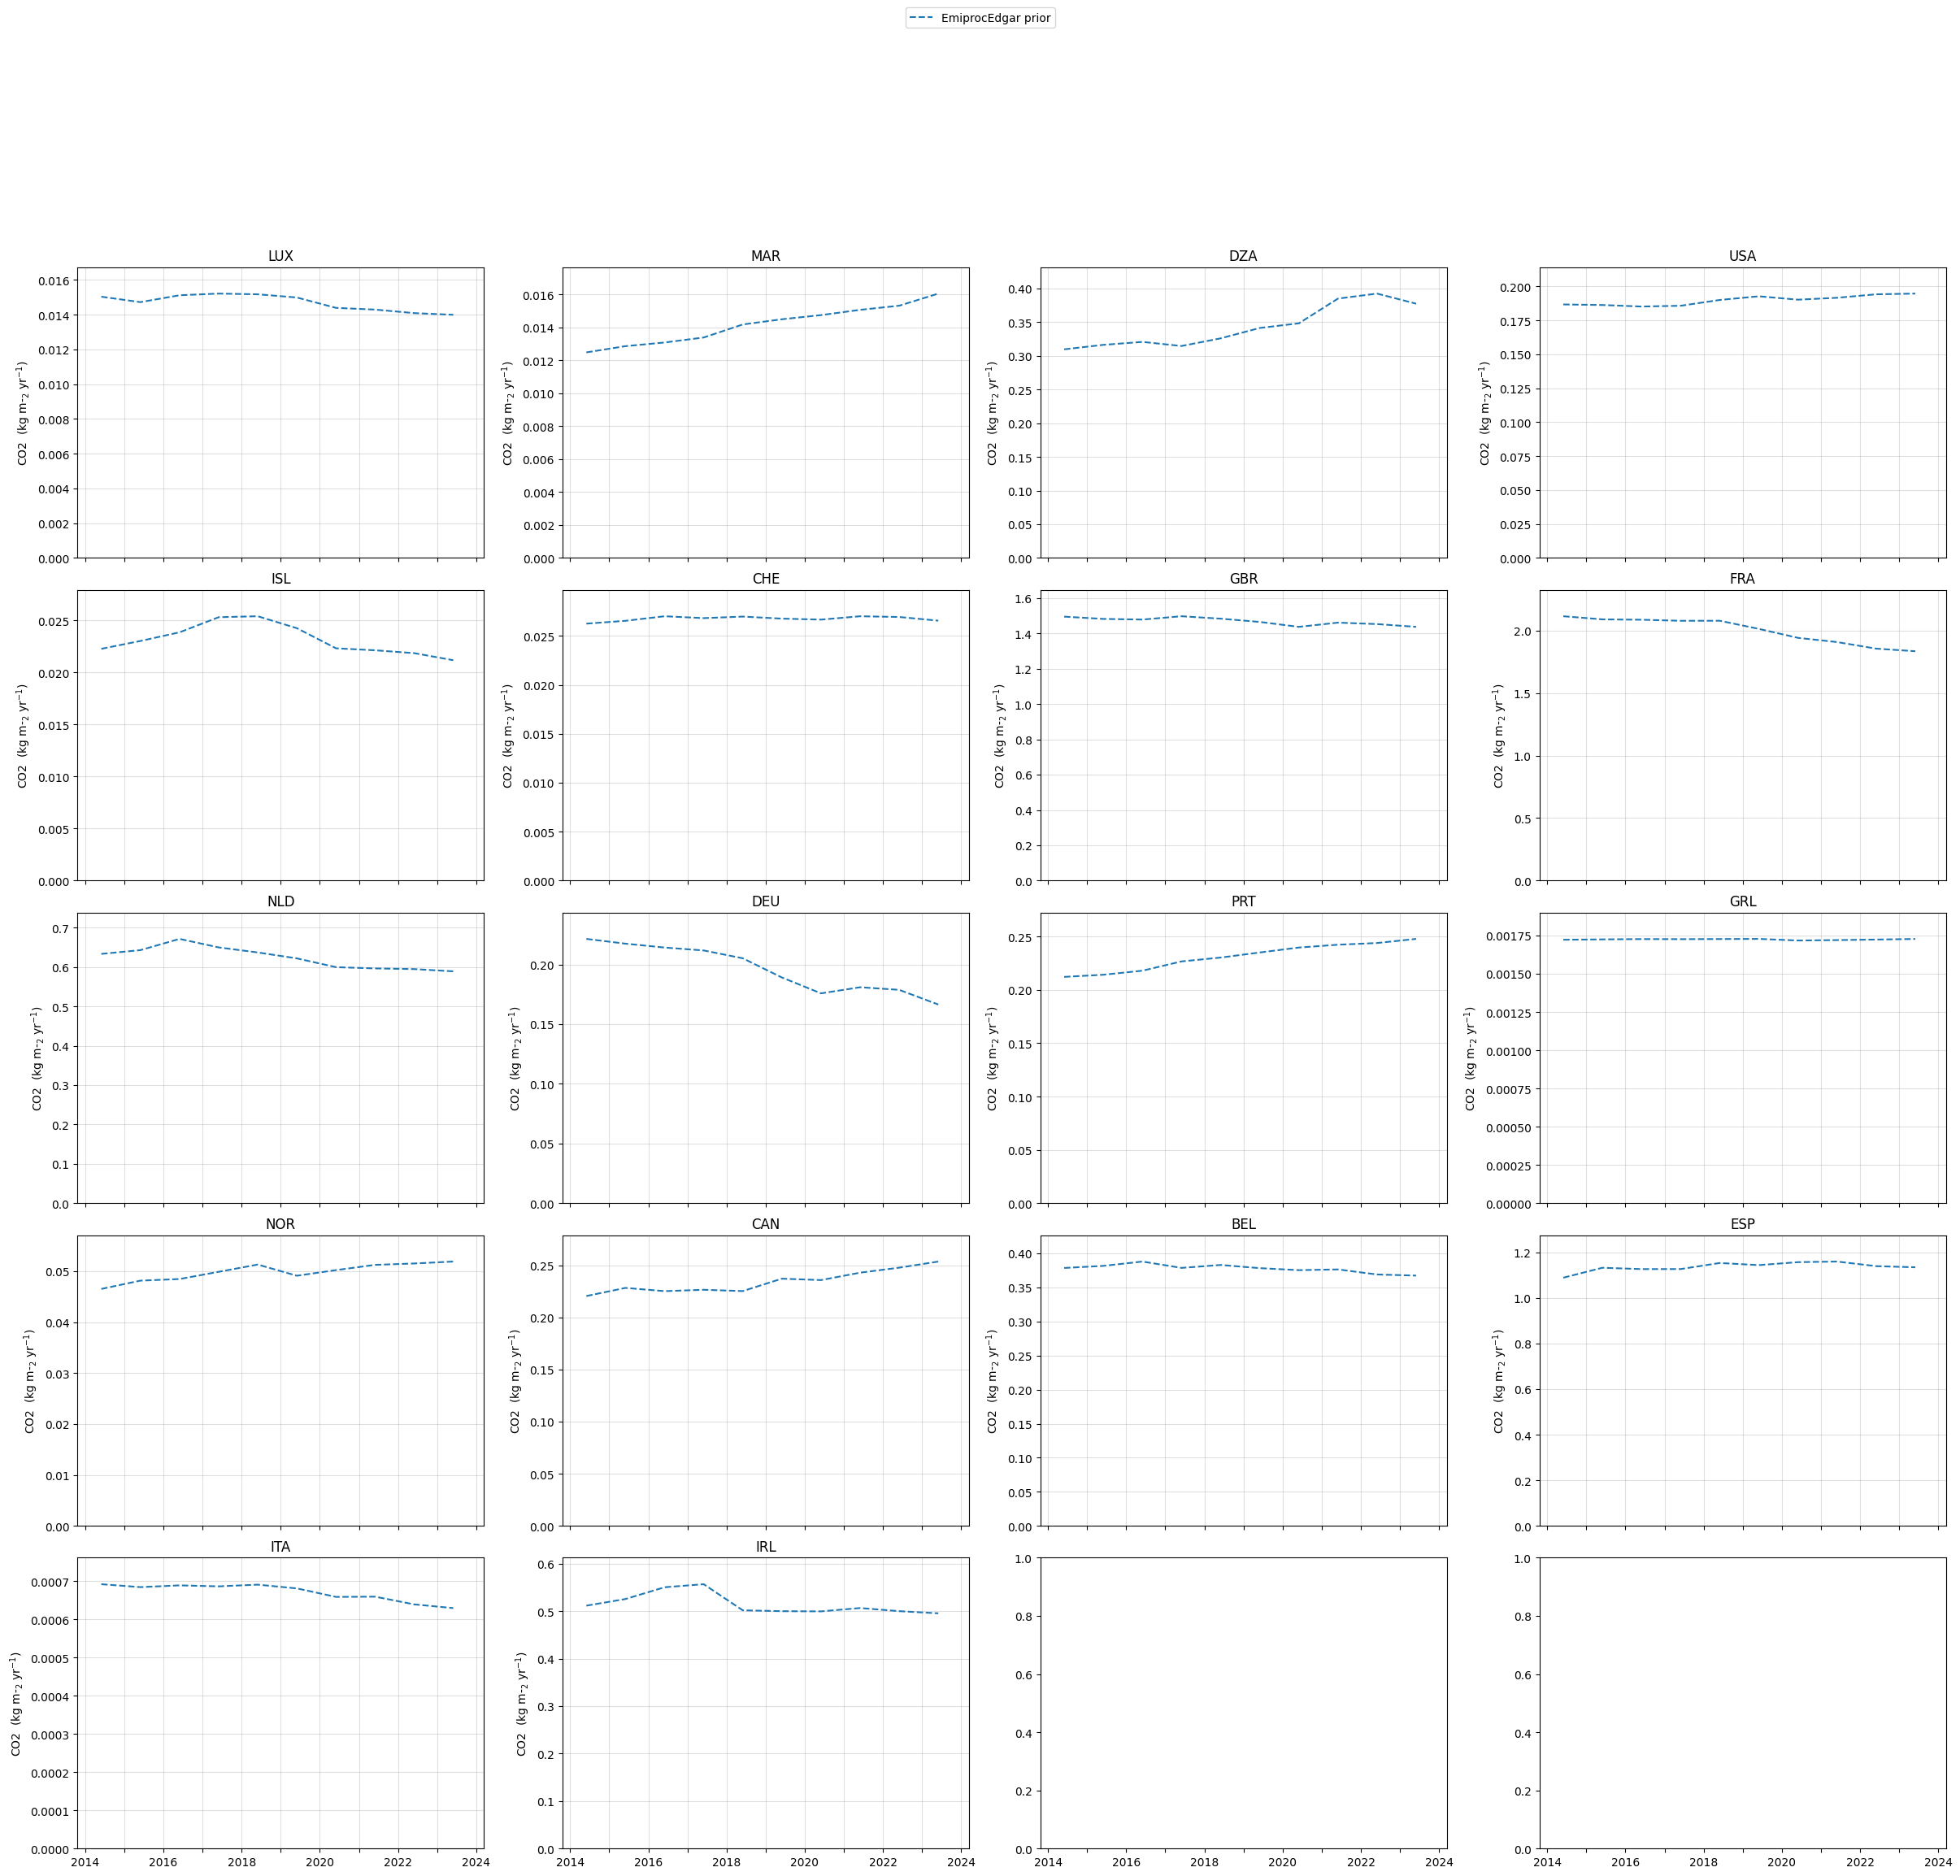

In [ ]:
from fluxy.plots.flux_timeseries import  plot_country_flux

# This function plots timeseries of the total fluxes for each country
fig = plot_country_flux(
    dss_fluxy,
    species='CO2', 
    # Set to false, otherwise it will try to look for files you don't have
    plot_inventory=False, 
    set_global_leg=True,
)